In [1]:
import urllib.request
url = 'https://raw.githubusercontent.com/tommytracey/AIND-Capstone/master/data/small_vocab_en'
filename = 'small_vocab_en.txt'
urllib.request.urlretrieve(url, filename)

('small_vocab_en.txt', <http.client.HTTPMessage at 0x16aa046ff40>)

In [2]:
url = 'https://raw.githubusercontent.com/tommytracey/AIND-Capstone/master/data/small_vocab_fr'
filename = 'small_vocab_fr.txt'
urllib.request.urlretrieve(url, filename)

('small_vocab_fr.txt', <http.client.HTTPMessage at 0x16aa0b72820>)

In [3]:
url = 'https://raw.githubusercontent.com/tommytracey/AIND-Capstone/master/project_tests.py'
filename = 'project_tests.py'
urllib.request.urlretrieve(url, filename)

('project_tests.py', <http.client.HTTPMessage at 0x16aa0b75c10>)

In [5]:
import collections

import numpy as np
#import project_tests as tests
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
#from tensorflow.keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11809370895169794917
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5732106240
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13670570335642104736
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6"
]


In [7]:
import os

input_file = os.path.join('small_vocab_en.txt')
with open(input_file, "r") as f:
    data = f.read()

In [8]:
english_sentences = data.split('\n')

In [9]:
input_file = os.path.join('small_vocab_fr.txt')
with open(input_file, "r") as f:
    data2 = f.read()

In [10]:
french_sentences = data2.split('\n')

In [11]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

In [12]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    return pad_sequences(x, maxlen=length, padding='post')

In [13]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 345


In [14]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [17]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.003
    
   # Build the layers    
    model = Sequential()
    # Embedding
    model.add(tf.keras.layers.Embedding(english_vocab_size, 128, input_length=input_shape[1],
                         input_shape=input_shape[1:]))
    # Encoder
    model.add(Bidirectional(GRU(128)))
    model.add(RepeatVector(output_sequence_length))
    # Decoder
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model


In [39]:
def final_predictions(x, y, x_tk, y_tk):
    """
    Gets predictions using the final model
    :param x: Preprocessed English data
    :param y: Preprocessed French data
    :param x_tk: English tokenizer
    :param y_tk: French tokenizer
    """
    # TODO: Train neural network using model_final
    model = model_final(x.shape,y.shape[1],
                        len(x_tk.word_index)+1,
                        len(y_tk.word_index)+1)
    model.summary()
    model.fit(x, y, batch_size=1024, epochs=25, validation_split=0.2)

    
    ## DON'T EDIT ANYTHING BELOW THIS LINE
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'

    sentence = 'he saw a old yellow truck'
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences, len(sentences))

    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('Il a vu un vieux camion jaune')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))


final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)

C:\Users\jesse\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 128)           25600     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               198144    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 21, 256)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 21, 256)           296448    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 21, 512)           131584    
_________________________________________

KeyboardInterrupt: 

In [18]:
model_1 = model_final(preproc_english_sentences.shape,preproc_french_sentences.shape[1],
                    len(english_tokenizer.word_index)+1,
                    len(french_tokenizer.word_index)+1)

In [24]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 128)           25600     
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               198144    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 21, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 256)           296448    
_________________________________________________________________
time_distributed (TimeDistri (None, 21, 512)           131584    
_________________________________________________________________
dropout (Dropout)            (None, 21, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 346)          

In [20]:
history_1 = model_1.fit(preproc_english_sentences, preproc_french_sentences, batch_size=1024, epochs=50, validation_split=0.2)

Epoch 1/50
108/108 [==============================] - 16s 49ms/step - loss: 2.5032 - accuracy: 0.4800 - val_loss: 1.5844 - val_accuracy: 0.5954
Epoch 2/50
108/108 [==============================] - 4s 38ms/step - loss: 1.4414 - accuracy: 0.6165 - val_loss: 1.1679 - val_accuracy: 0.6742
Epoch 3/50
108/108 [==============================] - 4s 38ms/step - loss: 1.1536 - accuracy: 0.6753 - val_loss: 1.1768 - val_accuracy: 0.6714
Epoch 4/50
108/108 [==============================] - 4s 38ms/step - loss: 1.0146 - accuracy: 0.7058 - val_loss: 0.8371 - val_accuracy: 0.7472
Epoch 5/50
108/108 [==============================] - 4s 38ms/step - loss: 0.8481 - accuracy: 0.7433 - val_loss: 0.6962 - val_accuracy: 0.7862
Epoch 6/50
108/108 [==============================] - 4s 39ms/step - loss: 0.7330 - accuracy: 0.7733 - val_loss: 0.5700 - val_accuracy: 0.8233
Epoch 7/50
108/108 [==============================] - 4s 39ms/step - loss: 0.5953 - accuracy: 0.8120 - val_loss: 0.4747 - val_accuracy: 0.853

In [21]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

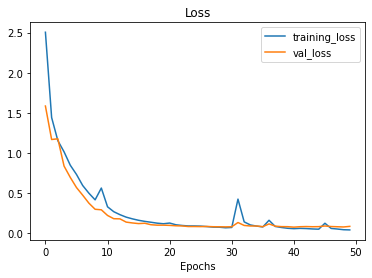

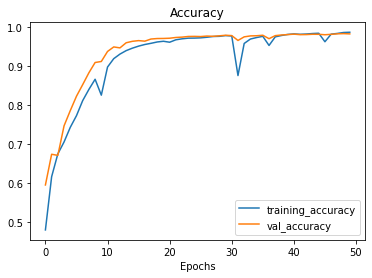

In [23]:
import matplotlib.pyplot as plt
plot_loss_curves(history_1)